# Transfer Learning

![tranfer_inner_chi](assets/transfer/transfer_inner_chi.jpg)

(image: kuailexiaorongrong.blog.163.com, via https://sg.news.yahoo.com/6-kungfu-moves-movies-wished-194241611.html)

# Topics

- Introduction & motivation
- Adapting Neural Networks
- Process

# Transfer Learning

Transfering the knowledge of one model to perform a new task.

"Domain Adaptation"

## Motivation

- Lots of data, time, resources needed to train and tune a neural network from scratch
  - An ImageNet deep neural net can take weeks to train and fine-tune from scratch.
  - Unless you have 256 GPUs, possible to achieve in [1 hour](https://research.fb.com/publications/accurate-large-minibatch-sgd-training-imagenet-in-1-hour/)
- Cheaper, faster way of adapting a neural network by exploiting their generalization properties

## Traditional vs. Transfer Learning

![tradition_v_transfer](assets/transfer/traditional_v_transfer.png)

(image: [Survey on Transfer Learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf))

## Transfer Learning Types


|Type|Description|Examples|
|--|--|--|
|Inductive|Adapt existing **supervised** training model on new **labeled** dataset|Classification, Regression|
|Transductive|Adapt existing **supervised** training model on new **unlabeled** dataset|Classification, Regression|
|Unsupervised|Adapt existing **unsupervised** training model on new **unlabeled** dataset|Clustering, Dimensionality Reduction|

## Transfer Learning Applications

- Image classification (most common): learn new image classes
- Text sentiment classification
- Text translation to new languages
- Speaker adaptation in speech recognition
- Question answering

## Transfer Learning Services

Transfer learning is used in many "train your own AI model" services:
  - just upload 5-10 images to train a new model! in minutes!

![custom vision](assets/transfer/custom-vision.png)

(image: https://azure.microsoft.com/en-us/services/cognitive-services/custom-vision-service/)

# Transfer Learning in Neural Networks

## Neural Network Layers: General to Specific 

- Bottom/first/earlier layers: general learners
 - Low-level notions of edges, visual shapes

- Top/last/later layers: specific learners
  - High-level features such as eyes, feathers
  
Note: the top/bottom notation is confusing, I'd avoid it

## Example: VGG 16 Filters

![vgg filters](assets/transfer/vgg16_filters_overview.jpg)

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

![overview](assets/transfer/Transfer+Learning+Overview.jpg)

(image: [Aghamirzaie & Salomon](http://slideplayer.com/slide/8370683/))

# Process

1. Start with pre-trained network

2. Partition network into:
 - Featurizers: identify which layers to keep
 - Classifiers: identify which layers to replace

3. Re-train classifier layers with new data

4. Unfreeze weights and fine-tune whole network with smaller learning rate

## Freezing and Fine-tuning

![vgg 16 modified](assets/transfer/vgg16_modified.png)

(image: http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Which layers to re-train?

- Depends on the domain
- Start by re-training the last layers (last full-connected and last convolutional)
  - work backwards if performance is not satisfactory

## Example

![transfer performance](assets/transfer/transfer_performance.png)

(image: http://arxiv.org/abs/1411.1792)

## When and how to fine-tune?

Suppose we have model A, trained on dataset A
Q: How do we apply transfer learning to dataset B to create model B?

|Dataset size|Dataset similarity|Recommendation|
|--|--|--|
|Large|Very different|Train model B from scratch, initialize weights from model A|
|Large|Similar|OK to fine-tune (less likely to overfit)|
|Small|Very different|Train classifier using the earlier layers (later layers won't help much)|
|Small|Similar|Don't fine-tune (overfitting). Train a linear classifier|

https://cs231n.github.io/transfer-learning/

## Learning Rates

- Training linear classifier: typical learning rate

- Fine-tuning: use smaller learning rate to avoid distorting the existing weights
  - Assumes weights are close to "good"

# Workshop: Learning New Image Classes

In this workshop, we will:
- Create a dataset of new classes not found in ImageNet
- Perform inductive transfer learning on a pre-trained ImageNet neural network
- Evaluate the results

Credits: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Choose your own dataset

We will create a new dataset to perform a new multi-class classification task.

1. Pick a category that is NOT found in ImageNet
  - For reference, the 1000 imagenet classes are here: http://image-net.org/challenges/LSVRC/2014/browse-synsets

2. Download your images from the web. Organize them in a directory structure like this:
```
data/
    train/
        chapati/
            chapati001.jpg
            chapati002.jpg
            ...
        fishball_noodle/
            fishball_noodle001.jpg
            fishball_noodle002.jpg
            ...
        satay/
            satay001.jpg
            satay002.jpg
            ...
    validation/
        chapati/
            chapati001.jpg
            chapati002.jpg
            ...
        fishball_noodle/
            fishball_noodle001.jpg
            fishball_noodle002.jpg
            ...
        satay/
            satay001.jpg
            satay002.jpg
            ...
```            

### Guidelines
  - Pick classes that have distinctive image characteristics
     - For example, circles, lines, patterns.
  - Provide at least 20 training images per class. The more the better, to avoid overfitting.
  - Use different images for the training and validation sets.
  - Use any standard image format, such as jpg and png 
  - A sample dataset is available in the data folder. Warning: it may make you hungry.

### Set dataset path and labels
Update `dataset_path` with the path to your dataset
- You can use an absolute path (e.g. 'D:/tmp/data') or a relative path

Update `labels` with the labels for your dataset

In [1]:
# Update to set the path of your dataset
# You can use an absolute path (e.g. 'D:/tmp/data') or a relative path
dataset_path='./data'

# Update to set the labels for your dataset
labels=['chapati', 'fishball_noodle', 'satay']

n_classes=len(labels)
print('Num classes:', n_classes)

Num classes: 3


In [2]:
def count_image_files(folder_name, extensions=['png', 'jpg']):
    """Counts 1-level nested image files in a folder
    Arg:
        folder_name: name of folder to search
        extensions: array of image file extensions
    Returns:
        number of image files
    """
    from functools import reduce
    import glob
    return reduce((lambda x, y: x + y),
        [len(glob.glob('%s/**/*.%s' % (folder_name, ext), recursive=True))
            for ext in extensions])

In [3]:
import os

train_folder = os.path.join(dataset_path, 'train')
n_train_set = count_image_files(train_folder)

print('Training set size:', n_train_set)

val_folder = os.path.join(dataset_path, 'validation')
n_val_set = count_image_files(val_folder)
print('Validation set size:', n_val_set)

Training set size: 45
Validation set size: 15


### Perform Data Augmentation

- Data Augmentation is a technique to improve the performance of classification models
  - This is especially helpful for small training datasets
  - http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf

- We will use `keras.preprocessing.image.ImageDataGenerator` to randomly rotate and horizontal flip our training data.
  - This is documented in https://keras.io/preprocessing/image/

Found 45 images belonging to 3 classes.


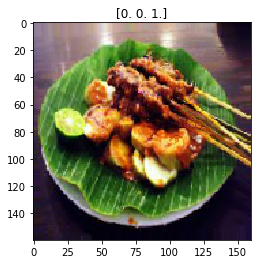

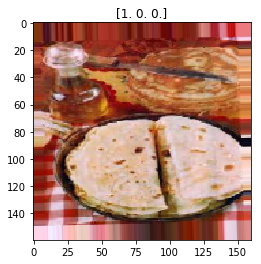

In [8]:
# https://keras.io/preprocessing/image/#imagedatagenerator-class
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 160x160 matches one of the sizes supported by MobileNet
# (the neural network we'll transfer learn from)
img_height = img_width = 160
channels = 3

datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=5,
                            zoom_range=.2,
                            horizontal_flip=True)

# generate image data from the training set
generator = datagen.flow_from_directory(train_folder,
                                        color_mode='rgb',
                                        target_size=(img_height, img_width),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=True)

# display some images
x, y = next(generator)
plt.imshow(x[0])
plt.title(y[0])
plt.show()

x, y = next(generator)
plt.imshow(x[0])
plt.title(y[0])
plt.show()

## Baseline Model - 4-layer CNN from scratch

As a baseline, let's train a simple Convolutional Neural Network to do multi-class classification.

This will be trained from scratch and compared against the transfer learning model(s).

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation,\
    BatchNormalization, Flatten, Dense

model = Sequential()

# Convolutional Block 1
# depth 8, kernel 3, stride 1, with padding
# input shape: 160, 160, 3 
# output shape (of the block): 53, 53, 8
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same',
                 activation='relu',
                 input_shape=(img_width, img_height, channels)))
# Note: input_shape is inferred for subsequent layers
#output shape of the Conv2D : 160,160,8
model.add(MaxPool2D(pool_size=(3,3)))
#output shape of block 160/3(pool size) , 160/3(pool size) , 8 ==> 53,53,8

# Convolutional Block 2
# depth 16, kernel 3, stride 1, with padding
# input shape: 53, 53, 8 
# output shape (of the block): 26, 26, 16
# Note: Batch norm is inserted before activation for 2nd conv block onwards
#       Batch Norm removes noise in the covariates (means, variances)
#       when we stack convolutional blocks
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 3
# depth 32, kernel 3, stride 1, with padding
# input shape: 26, 26, 16
# output shape (of the block): 13, 13, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Block 4
# depth 32, kernel 3, stride 1, with padding
# input shape: 13, 13, 32
# output shape (of the block): 6, 6, 32
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Classifier
# input shape: 6, 6, 32
# output shape: 3
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 53, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        4640      
__________

### TensorBoard - Monitoring Training Progress

This is the first time we're training neural networks in keras.
- We'll be using the default backend of keras, which is Tensorflow.
- Therefore, we can use [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) to view training progress and metrics.

TensorBoard is already included in Tensorflow, so there is no separate installation required.

### Launching TensorBoard

#### Windows
Launch a new Anaconda prompt:

```
activate mldds03
cd \path\to\mldds-courseware\03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

#### MacOS / Ubuntu
Launch a new terminal:

```
source activate mldds03
cd /path/to/mldds-courseware/03_TextImage
mkdir logs
tensorboard --logdir=./logs --host=0.0.0.0 --port=8008
```

### Viewing TensorBoard

Once you see TensorBoard launched, you can navigate to http://localhost:8008

In [7]:
from keras.callbacks import EarlyStopping, TensorBoard
import time

batch_size = 1 # feel free to increase this if you have more images

train_generator = datagen.flow_from_directory(train_folder,
                                              color_mode='rgb',
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)
# TensorBoard
# make a unique log index so that it's easier to filter
# by training sessions
log_index = int(time.time())

# we set histogram_freq=0 because we are using a generator
tensorboard = TensorBoard(log_dir='./logs/baseline_cnn/%s' % log_index,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

# Avoid overfitting by setting up early stopping
early_stopping = EarlyStopping(monitor='loss', patience=0,
                               verbose=0, mode='auto')

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,
                    n_train_set//batch_size,
                    epochs=15,
                    callbacks=[tensorboard, early_stopping])

Found 45 images belonging to 3 classes.
Epoch 1/15
45/45 [==============================] - 3s 67ms/step - loss: 1.7135 - acc: 0.4000
Epoch 2/15
45/45 [==============================] - 3s 58ms/step - loss: 1.0887 - acc: 0.6000
Epoch 3/15
45/45 [==============================] - 3s 56ms/step - loss: 0.6263 - acc: 0.7556
Epoch 4/15
45/45 [==============================] - 2s 55ms/step - loss: 0.4686 - acc: 0.7778
Epoch 5/15
45/45 [==============================] - 2s 55ms/step - loss: 0.4056 - acc: 0.8444
Epoch 6/15
45/45 [==============================] - 2s 55ms/step - loss: 0.3113 - acc: 0.8667
Epoch 7/15
45/45 [==============================] - 3s 59ms/step - loss: 0.2263 - acc: 0.9333
Epoch 8/15
45/45 [==============================] - 3s 56ms/step - loss: 0.1246 - acc: 0.9556
Epoch 9/15
45/45 [==============================] - 3s 56ms/step - loss: 0.1180 - acc: 0.9556
Epoch 10/15
45/45 [==============================] - 2s 55ms/step - loss: 0.1388 - acc: 0.9778


### Scikit-Learn vs. Keras

sklearn:
```
# Model
logistic = LogisticRegression(random_state=42)

# Fit
logistic.fit(X_train_scaled, y_train)

# Predict
y_pred_logistic = logistic.predict(X_test_scaled)

# Metrics
print(classification_report(y_test, y_pred_logistic))

# Save / Load
import pickle
pickle.dump(X_scaler, open('X_scaler.pickle', 'wb'))
pickle.dump(logistic, open('model.pickle', 'wb'))

logistic_1 = pickle.load(open('model.pickle', 'rb'))

```

keras:
```
# Model

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same',
                 activation='relu',
                 input_shape=(img_width, img_height, channels)))
model.add(MaxPool2D(pool_size=(3,3)))

<etc...>

# Fit

tensorboard = TensorBoard(log_dir='./logs/baseline_cnn/%s' % int(time.time()),
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                               verbose=1, mode='auto')

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator,
                    n_train_set//batch_size,
                    epochs=100,
                    validation_data=test_generator, # testing data
                    callbacks=[tensorboard, early_stopping])

# Predict

pred_y = model.predict(test_x)


# Metrics

# convert numbers into one-hot rows
bins = np.array([0.5]) # x <= 0.5 becomes 0, else 1
pred_y_onehot = np.digitize(pred_y, bins)

# convert one-hot rows to label index
pred_y_labels = pred_y_onehot.argmax(axis=1)

print(classification_report(test_y, pred_y_labels))

# Save / Load

from keras.models import load_model
model.save('my_model.h5')

my_model = load_model('my_model.h5')


You can view training progress from Tensorboard by going to http://localhost:8008

![tensorboard](assets/transfer/tensorboard-demo.png)

## Exercise - Classification Model Validation
 
1. Create a test_generator using datagen.flow_from_directory, but point it to the validation folder and set batch_size to all available test samples

```
# no data augmentation for the test set
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(val_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_val_set,
                                                  class_mode='categorical',
                                                  shuffle=False)
test_x, test_y = next(test_generator)
```

2. Run predictions using the CNN we just trained
```
pred_y = model.predict(test_x)
```

3. The predictions from the CNN are continuous values, so we need to convert them to categorical.

```
# convert numbers into one-hot rows
bins = np.array([0.5]) # x <= 0.5 becomes 0, else 1
pred_y_onehot = np.digitize(pred_y, bins)

# convert one-hot rows to label index
pred_y_labels = pred_y_onehot.argmax(axis=1)

```
4. Use sklearn.metrics to evaluate the classification model (using confusion_matrix, classification_report). Note that confusion_matrix takes in label indices, not one-hot arrays.

### Setup

You may need to install sklearn into your conda environment.

```
conda install scikit-learn
```

In [22]:
# Your code here


#Create a test_generator using datagen.flow_from_directory, 
#but point it to the validation folder and set batch_size to all available test samples
# no data augmentation for the test set
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(val_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_val_set,
                                                  class_mode='categorical',
                                                  shuffle=False)
test_x, test_y = next(test_generator)
#Run predictions using the CNN we just trained

pred_y = model.predict(test_x)
#The predictions from the CNN are continuous values, so we need to convert them to categorical.

# convert numbers into one-hot rows--Digitize converts <=0.5  to 0 , else 1
#bins = np.array([0.5]) # x <= 0.5 becomes 0, else 1
#pred_y_onehot = np.digitize(pred_y, bins)

# convert one-hot rows to label index
pred_y_labels = pred_y.argmax(axis=1)


print(pred_y_labels)
print(test_y)

# convert truth one-hot rows to label index
test_y_labels = test_y.argmax(axis=1)
print(test_y_labels)


Found 15 images belonging to 3 classes.
[0 2 2 1 1 1 1 2 2 0 2 2 2 2 2]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


             precision    recall  f1-score   support

          0       0.50      0.20      0.29         5
          1       0.50      0.40      0.44         5
          2       0.56      1.00      0.71         5

avg / total       0.52      0.53      0.48        15

[[1 2 2]
 [1 2 2]
 [0 0 5]]


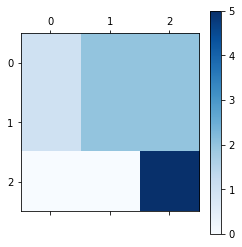

In [24]:
#Use sklearn.metrics to evaluate the classification model
#(using confusion_matrix, classification_report). 
#Note that confusion_matrix takes in label indices, not one-hot arrays.

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print(classification_report(test_y, pred_y_onehot))

cm = confusion_matrix(test_y_labels,pred_y_labels)
print(cm)



plt.matshow(cm, cmap='Blues')
plt.colorbar()







If you used the sample dataset, you should get classification metrics similar to this:
```
Found 15 images belonging to 3 classes.
             precision    recall  f1-score   support

          0       0.38      0.60      0.46         5
          1       1.00      0.20      0.33         5
          2       0.50      0.60      0.55         5

avg / total       0.62      0.47      0.45        15

[[3 0 2]
 [3 1 1]
 [2 0 3]]
```

This baseline model doesn't perform too well.  Let's see what we get with Transfer Learning.

## Transfer Learning with ImageNet MobileNet

Now that we have our baseline CNN, let's try transfer learning. 

2 Steps:
1. Freeze and retrain a classifier on top of MobileNet
2. Un-freeze and fine-tune the model we got from step 2

### Load the featurizer portion of MobileNet

In [26]:
from keras.applications import MobileNet

# Exclude the Dense layer from the network by setting include_top=False
# We are going to re-train a classifier with the remaining layers
featurizer = MobileNet(include_top=False,
                       weights='imagenet',
                       input_shape=(img_width, img_height, channels))
featurizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
__________

### Freeze the featurizer weights

If the weights and labels were not previously saved:
  1. Run the training set through the MobileNet featurizer
  2. Save the output of the featurizer and corresponding training set labels

Else load the weights and labels from files.

Since this is supervised learning, we need both the weights and labels to train the classifier.

In [ ]:
# For large neural networks such as VGG, it is a good idea to save the
# weights to a file that we load during transfer learning training.

# https://wiki.python.org/moin/UsingPickle
import pickle
weights_file = 'mobilenet_features_train.npy'
labels_file = 'mobilenet_labels_train.npy'

batch_size = 1 # feel free to increase this if you have more images

if os.path.isfile(weights_file) and os.path.isfile(labels_file):
    print('Loading weights from %s:' % weights_file)
    with open(weights_file, 'rb') as f:
        features_train = pickle.load(f)
        
    print('Loading labels from %s:' % labels_file)
    with open(labels_file, 'rb') as f:
        labels_train = pickle.load(f)
        
else:
    print('Saving weights to %s:' % weights_file)
    train_generator = datagen.flow_from_directory(train_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_train_set,
                                                  class_mode='categorical')

    print('Saving labels to %s:' % labels_file)
    
    # capture the featurizer weights and labels
    train_x, labels_train = next(train_generator)

    features_train = featurizer.predict(train_x)    

    # save to file
    pickle.dump(features_train, open(weights_file, 'wb'))
    pickle.dump(labels_train, open(labels_file, 'wb'))
    
print('features_train.shape:', features_train.shape)
print('labels_train:', labels_train)

### Train a new classifier with the frozen weights

Now that we have the featurizer weights, we can:

1. Create a general classifier.
2. Train the classifier with the weights (X) and labels (y).

#### Create a general classifier

Note that this classifier does not have to be related to the architecture of the original network.

It simply treats the inputs as opaque features.

In [ ]:
from keras.layers import Flatten, Dense, Dropout

classifier = Sequential()
classifier.add(Flatten(input_shape=features_train.shape[1:])) # flatten (5, 5, 1024) to vector
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(3, activation='softmax'))

classifier.summary()

## Exercise: Train the classifier

1. Setup a tensorboard callback

```
tensorboard = TensorBoard(log_dir='./logs/mobilenet_trf/%s' % log_index,
                             histogram_freq=0, write_graph=True, write_images=False)
```

2. Setup an EarlyStopping callback to monitor the validation loss. 
 - To understand what it does, try experimenting with these parameters or removing this callback to see what happens.
 - To disable this callback, you need to update the list of callbacks passed to `fit`
 - You should see overfitting if you disable the callback AND increase `epochs` for `fit`.

```
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')
```

3. Compile the model, then fit with the features and labels

```
classifier.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy', metrics=['accuracy'])

classifier.fit(x=features_train,
               y=labels_train,
               validation_split=0.2,
               batch_size=batch_size,
               epochs=10,
               callbacks=[tensorboard, early_stopping])
```

If you run `fit` multiple times, you may notice that the model continues training from the previous call to `fit`.
 - To reset the model state, you may find it useful to just re-declare the model before calling `fit`.

In [73]:
# Your code here
























### Evaluate the model

Evaluating the transfer learnt model is not as straightforward as giving it the test inputs.

We'll need to:
1. Get the validation set features (and labels) from the MobileNet featurizer
2. Pass the features into the classifier to get the predictions.

In [ ]:
test_generator = test_datagen.flow_from_directory(val_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_val_set,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Get the validation set features (and labels) from the MobileNet featurizer
test_x, test_y = next(test_generator)
test_features = featurizer.predict(test_x)

# Pass the features into the classifier to get the predictions.
pred_y = classifier.predict(test_features)

# convert numbers into one-hot rows
bins = np.array([0.5]) # x <= 0.5 becomes 0, else 1
pred_y_onehot = np.digitize(pred_y, bins)

# convert one-hot rows to label index
pred_y_labels = pred_y_onehot.argmax(axis=1)

# Evaluate metrics
print(classification_report(test_y, pred_y_onehot))
print(confusion_matrix(test_y.argmax(axis=1), pred_y_labels))

If you are using the sample dataset, you should get classification metrics similar to this:

```
Found 15 images belonging to 3 classes.
             precision    recall  f1-score   support

          0       0.71      1.00      0.83         5
          1       1.00      1.00      1.00         5
          2       1.00      0.60      0.75         5

avg / total       0.90      0.87      0.86        15

[[5 0 0]
 [0 5 0]
 [2 0 3]]
```

A much better improvement from the baseline model.

## Fine-tuning the Featurizer

To further improve the result, we can try to "fine-tune" the last few layers of the featurizer.

Let's examine the architecture:

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# We can plot the featurizer architecture
SVG(model_to_dot(featurizer, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# We can also plot the classifier architecture 
SVG(model_to_dot(classifier, show_shapes=True).create(prog='dot', format='svg'))

### MobileNet Convolutional Block
MobileNet is unique in that it's convolutional block is actually a Depthwise-separable block.
 - This speeds up the network and reduces the number of parameters it needs to store
 - This means that we should fine-tune the last `Depthwise Conv2D` and `Conv2D` blocks **as a unit**, because together they perform the standard convolution operation.

![Depthwise Separable Conv Block](assets/transfer/depthwise_conv_block.png)

(image: https://arxiv.org/abs/1704.04861)

If you are interested, slides and demos on a talk on optimzed neural nets for mobile devices: https://github.com/lisaong/stackup-workshops/blob/master/ai-edge

This picture shows the candidate layers to be fine-tuned (in yellow).

![fine tune candidates](assets/transfer/mobilenet-finetune.png)

### Construct Model for Fine-tuning
Now that we've identified the candidate layers, the next steps are to:

1. Create a new MobileNet featurizer with the ImageNet weights
2. Append the classifier we trained earlier to the featurizer
3. Freeze the featurizer layers that we don't want to fine-tune

In [ ]:
from keras.models import Model

# 1. Create a new MobileNet featurizer with the ImageNet weights
mobilenet = MobileNet(include_top=False,
                      weights='imagenet',
                      input_shape=(img_width, img_height, channels))

# 2. Append the classifier we trained earlier to the featurizer
combined_model = Model(inputs=mobilenet.input,
                       outputs=classifier(mobilenet.output))

# 3. Freeze the featurizer layers that we don't want to fine-tune

# first, we confirm these are the layers we want to keep unfrozen
combined_model.layers[-7:]

To freeze the other layers, we set `layer[index].trainable = False`

Once this is set, the model summary should show significantly fewer trainable parameters.

Weights (if any) for these last 7 layers will be trainable:

```
conv_dw_13 (DepthwiseConv2D) (None, 5, 5, 1024)        9216      
_________________________________________________________________
conv_dw_13_bn (BatchNormaliz (None, 5, 5, 1024)        4096      
_________________________________________________________________
conv_dw_13_relu (Activation) (None, 5, 5, 1024)        0         
_________________________________________________________________
conv_pw_13 (Conv2D)          (None, 5, 5, 1024)        1048576   
_________________________________________________________________
conv_pw_13_bn (BatchNormaliz (None, 5, 5, 1024)        4096      
_________________________________________________________________
conv_pw_13_relu (Activation) (None, 5, 5, 1024)        0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 3)                 1638659   
=================================================================
Total params: 4,867,523
Trainable params: 2,700,547
Non-trainable params: 2,166,976
_________________________________________________________________
```

In [ ]:
# Freeze the other layers
for layer in combined_model.layers[:-7]:
    layer.trainable = False
    
combined_model.summary()

### Setup Optimizer and Learning Rate for Fine-Tuning

For fine-tuning, we want to keep the learning rate slow, and avoid aggressive optimizers:
- Try RMSProp or SGD: https://keras.io/optimizers/
- Slow learning rate that decays exponentially

## Exercise: Train the combined model

Using the hints below, write the code to train the combined model.

1. Setup data augmentation for the training set. The code should be similar to what was done for saving the featurizer weights. 

```
# setup data augmentation in the same way as before
train_datagen = ImageDataGenerator(...)

# batch_size should be n_train_set
# the other setting should be similar to before
train_generator = train_datagen.flow_from_directory(...)

# get the training set
train_x, labels_train = next(train_generator)
```

2. Train the featurizer using SGD, with an exponentially decaying learning rate. Make sure that early stopping is more strict, because we don't want to overfit.

```
# compile the model
from keras.optimizers import SGD

combined_model.compile(loss='categorical_crossentropy',
                       optimizer=SGD(lr=1e-4, decay=0.9),
                       metrics=['accuracy'])

# setup tensorboard to track our logs in a separate folder for easy filtering
# the other settings should be similar to fitting the classifier
tensorboard = TensorBoard(log_dir='./logs/mobilenet_finetune/%s' % log_index, ...)

# let's be even more strict with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0,
                               verbose=0, mode='auto')

# finally, fine-tune the model.
# the other settings should be similar to fitting the classifier
# Note: since the learning rate is slow, we will need to increase the number of epochs
combined_model.fit(x=train_x,
                   y=labels_train,
                   epochs=30.
                   ...)
```

Note: you do not need to call `next(test_generator)` or `next(train_generator)` when using `fit_generator` for training.

In [ ]:
# Your code here





























### Evaluate the Combined Model

Last, but not the least, evalute the classification metrics for the combined model.

- Unlike the first Transfer Learning case, we do not need to pre-process the test samples through the featurizer and then the classifier.
- We can pass the test samples directly into the combined model.

If you were using the sample data, you should see a remarkable improvement in the F1 score:

```
Found 15 images belonging to 3 classes.
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         5
          1       0.83      1.00      0.91         5
          2       1.00      0.80      0.89         5

avg / total       0.94      0.93      0.93        15

[[5 0 0]
 [0 5 0]
 [0 1 4]]
```

In [ ]:
test_generator = test_datagen.flow_from_directory(val_folder,
                                                  color_mode='rgb',
                                                  target_size=(img_height, img_width),
                                                  batch_size=n_val_set,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Get the validation set features (and labels) from the MobileNet featurizer
test_x, test_y = next(test_generator)

# Pass the features into the combined model to get the predictions.
pred_y = combined_model.predict(test_x)

# convert numbers into one-hot rows
bins = np.array([0.5]) # x <= 0.5 becomes 0, else 1
pred_y_onehot = np.digitize(pred_y, bins)

# convert one-hot rows to label index
pred_y_labels = pred_y_onehot.argmax(axis=1)

# Evaluate metrics
print(classification_report(test_y, pred_y_onehot))
print(confusion_matrix(test_y.argmax(axis=1), pred_y_labels))

# Summary

This has been another looong workshop. It's easy to get lost in what we're trying to do.

#### Start
We started with a pre-trained MobileNet neural net.

#### Objective
Adapt it to a new dataset and a new task (new classes).

#### Process
1. Train a baseline classifier using a 4-layer Convolutional Neural Network

2. Transfer learning stage 1
 - Partition the MobileNet CNN into featurizer and classifier.
 - Freeze the featurizer weights.
 - Train a new classifier (transfer-learning classifier) using the featurizer weights as inputs.

3. Transfer learning stage 2: fine-tuning
 - Unfreeze the last convolutional block of the featurizer
 - Add the transfer-learning classifier to the featurizer to make a combined model
 - Re-train the combined model with a very slow learning rate.

# Reading List

|Material|Read it for|URL|
|--|--|--|
|A Survey on Transfer Learning (IEEE)|Overview of transfer learning|http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.147.9185&rep=rep1&type=pdf|
|Transductive Learning: Motivation, Model, Algorithms|Explanation of Induction vs. Transduction Transfer Learning|http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2527.pdf|
|Supervised and Unsupervised Transfer Learning for Question Answering (Paper)|More unique application of transfer learning|https://arxiv.org/abs/1711.05345|
|Building powerful image classification models using very little data|More walkthroughs and explanations of this workshop (we used this as the reference tutorial)|https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html|